In [1]:
import keras
import cv2
import h5py
from collections import Counter
from keras import backend as K
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

/Users/daichisato/anaconda/envs/lily/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("data_total.csv")

In [3]:
df.head()

,corner_flag,label,num_blob_100,num_blob_200,num_blob_300,num_blob_400,num_blob_500,patch_id
0,1,0,1,1,1,0,0,UT001100100
1,1,0,1,1,1,0,0,UT001100110
2,1,0,1,1,1,0,0,UT001100120
3,1,0,1,1,1,0,0,UT001100130
4,1,0,1,1,1,0,0,UT001100140


In [4]:
np.random.seed(12345)

In [5]:
df['patient_id'] = df.patch_id.str[:5]
df['blob_total'] = df.num_blob_100 + df.num_blob_200 + df.num_blob_300 + df.num_blob_400 + df.num_blob_500

df["label"].value_counts()

df_cancer = df.query('label == 1')
df_not_cancer = df.query('label == 0')

lengths = [len(df_cancer), len(df_not_cancer)]

mini = min(lengths)

df_cancer = df_cancer.sample(n=mini)
df_not_cancer = df_not_cancer.sample(n=mini)

df_2 = pd.concat([df_cancer, df_not_cancer])

df_Y = df_2[["label", "patient_id"]]
df_X = df_2.drop(["label"], axis=1)


test_p = 'UT001'

#### 説明変数・目的変数に分ける

In [6]:
X_train = df_X[df_X.patient_id != test_p].drop(['patch_id', 'patient_id'], axis=1)
X_test = df_X[df_X.patient_id == test_p].drop(['patch_id', 'patient_id'], axis=1)

Y_train = df_Y[df_Y.patient_id != test_p].drop('patient_id', axis=1)
Y_test = df_Y[df_Y.patient_id == test_p].drop('patient_id', axis=1)

In [7]:
from keras.utils.np_utils import to_categorical
x_train = np.array(X_train).astype('float32')
y_train = to_categorical(Y_train, 2)

x_test = np.array(X_test).astype('float32')
y_test = to_categorical(Y_test, 2) 


### Sequentialモデル

In [36]:
# モデルの作成
model = Sequential()

# モデルにレイヤーを積み上げていく
# 最初のレイヤーにはshapeを指定する必要がある
# 出力次元は手作業で探るしかない
# Dropout で過学習回避
model.add(Dense(7, activation='relu', input_shape = (7, )))
model.add(Dense(7, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [70]:
# 訓練プロセスの定義
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 984 samples, validate on 182 samples
Epoch 1/10
984/984 [==============================] - 1s 570us/step - loss: 0.2713 - acc: 0.4654 - val_loss: 0.2545 - val_acc: 0.4725
Epoch 2/10
984/984 [==============================] - 0s 72us/step - loss: 0.2372 - acc: 0.5193 - val_loss: 0.2550 - val_acc: 0.5879
Epoch 3/10
984/984 [==============================] - 0s 78us/step - loss: 0.2333 - acc: 0.5559 - val_loss: 0.2496 - val_acc: 0.5989
Epoch 4/10
984/984 [==============================] - 0s 76us/step - loss: 0.2299 - acc: 0.5711 - val_loss: 0.2496 - val_acc: 0.5989
Epoch 5/10
984/984 [==============================] - 0s 75us/step - loss: 0.2269 - acc: 0.5915 - val_loss: 0.2434 - val_acc: 0.6374
Epoch 6/10
984/984 [==============================] - 0s 75us/step - loss: 0.2236 - acc: 0.6138 - val_loss: 0.2399 - val_acc: 0.6813
Epoch 7/10
984/984 [==============================] - 0s 76us/step - loss: 0.2202 - acc: 0.6413 - val_loss: 0.2367 - val_acc: 0.6813
Epoch 8/10
984/984 [==

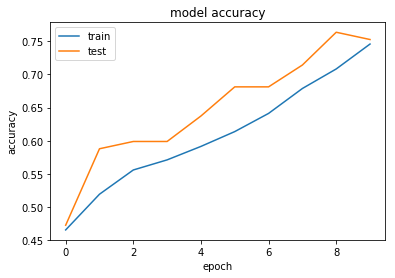

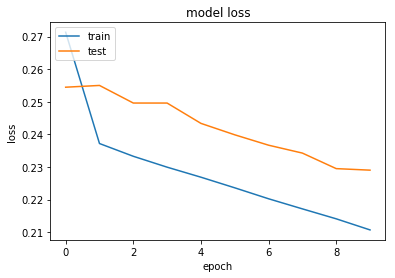

In [71]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
# 予測の実行
classes = model.predict(x_test)

In [50]:
#正答率のための準備
for_pred = pd.DataFrame(classes, columns = {'no_tumor', 'tumor'})
pred = for_pred.tumor.map(lambda x: 1 if x > 0.5 else 0 )

In [51]:
confmat = confusion_matrix(y_true=Y_test, y_pred=pred)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, pred))
print('recall: ', recall_score(Y_test, pred))

[[45 53]
 [84  0]]
accuracy :  0.24725274725274726
recall:  0.0


### 他のやり方

In [52]:
model = Sequential()

model.add(Dense(7, activation='relu', input_shape = (7, )))
model.add(Dropout(0.2))
model.add(Dense(7, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [53]:
# モデル
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 7)                 56        
_________________________________________________________________
dropout_3 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 56        
_________________________________________________________________
dropout_4 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 16        
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [54]:
# バッチサイズ、エポック数
batch_size = 128
epochs = 20

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 984 samples, validate on 182 samples
Epoch 1/20
984/984 [==============================] - 1s 630us/step - loss: 0.4190 - acc: 0.4827 - val_loss: 0.3731 - val_acc: 0.4121
Epoch 2/20
984/984 [==============================] - 0s 26us/step - loss: 0.3992 - acc: 0.4736 - val_loss: 0.3405 - val_acc: 0.4121
Epoch 3/20
984/984 [==============================] - 0s 26us/step - loss: 0.3856 - acc: 0.4705 - val_loss: 0.2937 - val_acc: 0.4121
Epoch 4/20
984/984 [==============================] - 0s 30us/step - loss: 0.3311 - acc: 0.5152 - val_loss: 0.2433 - val_acc: 0.4121
Epoch 5/20
984/984 [==============================] - 0s 28us/step - loss: 0.3020 - acc: 0.5224 - val_loss: 0.2199 - val_acc: 0.7473
Epoch 6/20
984/984 [==============================] - 0s 28us/step - loss: 0.2898 - acc: 0.5447 - val_loss: 0.2213 - val_acc: 0.6923
Epoch 7/20
984/984 [==============================] - 0s 29us/step - loss: 0.2889 - acc: 0.5539 - val_loss: 0.2220 - val_acc: 0.7802
Epoch 8/20
984/984 [==

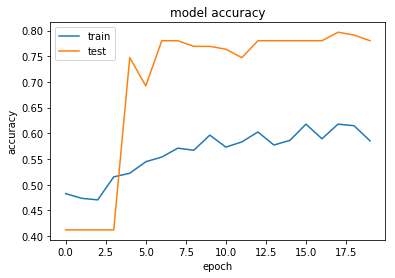

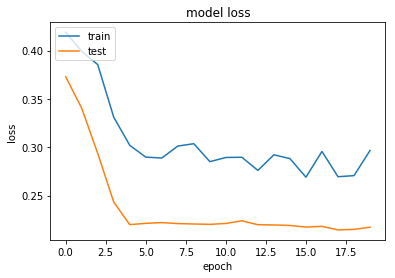

In [57]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN

In [8]:
import keras
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv1D, MaxPooling1D

In [9]:
df = pd.read_csv("data_total.csv")

### データの作成

In [10]:
df['patient_id'] = df.patch_id.str[:5]
df['blob_total'] = df.num_blob_100 + df.num_blob_200 + df.num_blob_300 + df.num_blob_400 + df.num_blob_500

df["label"].value_counts()

df_cancer = df.query('label == 1')
df_not_cancer = df.query('label == 0')

lengths = [len(df_cancer), len(df_not_cancer)]

mini = min(lengths)

df_cancer = df_cancer.sample(n=mini)
df_not_cancer = df_not_cancer.sample(n=mini)

df_2 = pd.concat([df_cancer, df_not_cancer])

df_Y = df_2[["label", "patient_id"]]
df_X = df_2.drop(["label"], axis=1)


test_p = 'UT008'

#### patient ごとの癌データの数

In [11]:
pd.DataFrame(df.groupby('patient_id').label.apply(Counter))

label
patient_id         
UT001      0   1643
           1     85
UT003      0   1609
           1    119
UT007      0    242
           1     46
UT008      0   1404
           1     84
UT009      0   1673
           1     55
UT010      0   1716
           1    108
UT011      0    814
           1     86

In [12]:
X_train = df_X[df_X.patient_id != test_p].drop(['patch_id', 'patient_id'], axis=1)
X_test = df_X[df_X.patient_id == test_p].drop(['patch_id', 'patient_id'], axis=1)

Y_train = df_Y[df_Y.patient_id != test_p].drop('patient_id', axis=1)
Y_test = df_Y[df_Y.patient_id == test_p].drop('patient_id', axis=1)

In [13]:
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

989
177
989
177


In [14]:
print(X_train.shape)
print(X_test.shape)

(989, 7)
(177, 7)


In [15]:
print(Counter(Y_train.label))
print(Counter(Y_test.label))

Counter({1: 499, 0: 490})
Counter({0: 93, 1: 84})


### CNNで使える形に整形

In [16]:
from keras.utils.np_utils import to_categorical
x_train = np.array(X_train).astype('float32')
y_train = to_categorical(Y_train, 2)

x_test = np.array(X_test).astype('float32')
y_test = to_categorical(Y_test, 2) 


In [17]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, 7)
    x_test = x_test.reshape(x_test.shape[0], 1, 7)
    input_shape = (1, 7)
else:
    x_train = x_train.reshape(x_train.shape[0], 7, 1)
    x_test = x_test.reshape(x_test.shape[0], 7, 1)
    input_shape = (7, 1)

In [26]:
batch_size = 128
epochs = 20
steps = 1
input_dim = 7

In [450]:
#model = Sequential()
#model.add(Conv1D(filters = 50, 
#                 kernel_size = 3,
#                 activation='relu',
#                 padding = 'same',
#                input_shape = (None, 7)))
#model.add(Conv1D(50, 3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))
#model.add(Dense(7, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='softmax'))

In [451]:
#model.compile(loss='mean_squared_error',
#              optimizer='sgd',
#              metrics=['accuracy'])
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
#          verbose=1, validation_data=(x_test, y_test))
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

### Functional API

#### 参考（https://qiita.com/anafou/items/7c4d57a70efb42d105a5）

In [19]:
K.image_dim_ordering()

'tf'

In [20]:
K.image_data_format()

'channels_last'

In [27]:
channels = 1
data_lengths = 7
kernel_size = 3
fillters = 50

In [28]:
def make_model(shape):
    input_layer = Input(batch_shape=shape)
    # 畳み込み層 1
    conv_1d_output_layer = Conv1D(fillters, kernel_size, padding='same', activation = 'relu')(input_layer)
    # プーリング層 1    
    max_pool_1d_output_layer = MaxPooling1D(pool_size=2)(conv_1d_output_layer)
    # 畳み込み層 2
    conv_1d_output_layer2 = Conv1D(fillters, kernel_size, padding='same', activation = 'relu')(max_pool_1d_output_layer)
    # プーリング層 2
    max_pool_1d_output_layer2 = MaxPooling1D(pool_size=2)(conv_1d_output_layer2)
    # 過学習防止
    dropout1_output_layer = Dropout(0.25)(max_pool_1d_output_layer2)
    # 平滑化
    flatten_output_layer = Flatten()(dropout1_output_layer)
    # 全結合
    prediction_result = Dense(2)(flatten_output_layer)

    model = Model(inputs=input_layer, outputs=prediction_result)
    return model

In [64]:
def make_model(shape):
    input_layer = Input(batch_shape=shape)
    # 畳み込み層 1
    conv_1d_output_layer = Conv1D(fillters, kernel_size, padding='same', activation = 'relu')(input_layer)
    # 過学習防止
    dropout1_output_layer = Dropout(0.25)(conv_1d_output_layer)
    # 畳み込み層 2
    conv_1d_output_layer2 = Conv1D(fillters, kernel_size, padding='same', activation = 'relu')(dropout1_output_layer)
    # 過学習防止
    dropout2_output_layer = Dropout(0.25)(conv_1d_output_layer2)
    # プーリング層 1    
    #max_pool_1d_output_layer = MaxPooling1D(pool_size=2)(conv_1d_output_layer)
    
    # プーリング層 2
    #max_pool_1d_output_layer2 = MaxPooling1D(pool_size=2)(conv_1d_output_layer2)
    
    # 平滑化
    flatten_output_layer = Flatten()(dropout2_output_layer)
    # 全結合
    prediction_result = Dense(2)(flatten_output_layer)

    model = Model(inputs=input_layer, outputs=prediction_result)
    return model

In [29]:
model_channels  = make_model(shape=(None, data_lengths, channels))

In [30]:
print('channels model')
print(model_channels.summary())

channels model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 50)             200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 50)             7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 50)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0     

In [31]:
batch_size = 128
epochs = 10

In [32]:
model_channels.compile(optimizer="sgd", loss='mse', metrics=['accuracy'])
history = model_channels.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=1,
                             validation_data=(x_test, y_test))

score = model_channels.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 999 samples, validate on 167 samples
Epoch 1/10
999/999 [==============================] - 1s 736us/step - loss: 0.4746 - acc: 0.5435 - val_loss: 0.2662 - val_acc: 0.8024
Epoch 2/10
999/999 [==============================] - 0s 64us/step - loss: 0.3129 - acc: 0.6196 - val_loss: 0.2379 - val_acc: 0.8323
Epoch 3/10
999/999 [==============================] - 0s 62us/step - loss: 0.2908 - acc: 0.6727 - val_loss: 0.2344 - val_acc: 0.8204
Epoch 4/10
999/999 [==============================] - 0s 74us/step - loss: 0.2747 - acc: 0.7057 - val_loss: 0.2260 - val_acc: 0.8204
Epoch 5/10
999/999 [==============================] - 0s 64us/step - loss: 0.2696 - acc: 0.7117 - val_loss: 0.2137 - val_acc: 0.8323
Epoch 6/10
999/999 [==============================] - 0s 60us/step - loss: 0.2596 - acc: 0.7157 - val_loss: 0.2131 - val_acc: 0.8204
Epoch 7/10
999/999 [==============================] - 0s 62us/step - loss: 0.2529 - acc: 0.7367 - val_loss: 0.2035 - val_acc: 0.8323
Epoch 8/10
999/999 [==

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img

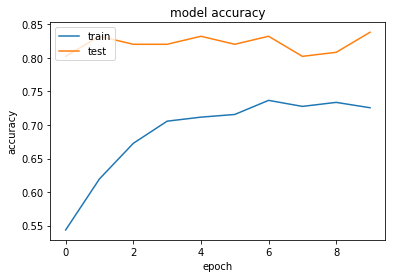

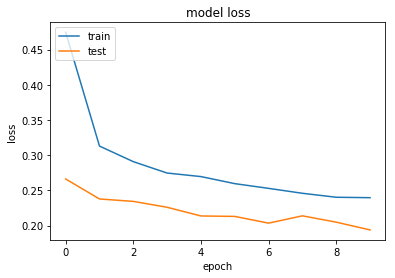

In [33]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
classes = model_channels.predict(x_test)

In [35]:
#正答率のための準備
for_pred = pd.DataFrame(classes, columns = {'no_tumor', 'tumor'})
pred = for_pred.tumor.map(lambda x: 1 if x > 0.5 else 0 )

In [36]:
confmat = confusion_matrix(y_true=Y_test, y_pred=pred)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, pred))
print('recall: ', recall_score(Y_test, pred))

[[52 31]
 [84  0]]
accuracy :  0.31137724550898205
recall:  0.0


In [75]:
print(Counter(Y_train.label))
print(Counter(Y_test.label))

Counter({1: 499, 0: 490})
Counter({0: 93, 1: 84})
